In [1]:
import torch
from torch import nn
import pandas as pd
import sklearn
import numpy as np
from sklearn.utils import shuffle
import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
from torch.utils.data import DataLoader, TensorDataset

In [2]:
def visualize_result(y_true,y_pred):
  cm = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cm, range(2), range(2))
  plt.figure(figsize=(10,7))
  sn.set(font_scale=1) 
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 20},fmt="d",cmap="YlGnBu") # font size
  from sklearn.metrics import classification_report
  from sklearn.metrics import f1_score,recall_score,precision_score
  target_names = ['class 0', 'class 1']
  print("f1_score "+" is :{}%".format(f1_score(y_true=y_true , y_pred= y_pred)))
  print("recall_score "+" is :{}%".format(recall_score(y_true=y_true , y_pred= y_pred)))
  print("precision_score "+" is :{}%".format(precision_score(y_true=y_true , y_pred= y_pred)))
  print(classification_report(y_true, y_pred, target_names=target_names))

In [3]:
data = pd.read_csv('datasets/EDA.csv')
data = data.iloc[: , 1:]
df = data
df = df.drop(columns = ["SalesAmountInEuro","product_price","time_delay_for_conversion","click_timestamp","product_title","day","day_time"])
df.head(5)

,Sale,nb_clicks_1week,product_age_group,device_type,audience_id,product_gender,product_brand,product_category(1),product_category(2),product_category(3),product_category(4),product_category(5),product_category(6),product_country,product_id,partner_id,user_id,day_time_category,tree_encode,category_encode
0,0.0,439.389006,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,6,0
1,0.0,439.389006,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,6,0
2,0.0,439.389006,1,1,0,1,1,1,1,0,0,0,0,1,2,1,2,16,12,3
3,0.0,439.389006,0,2,0,0,0,0,0,0,0,0,0,0,3,0,3,20,6,0
4,0.0,439.389006,1,0,0,2,2,2,2,1,1,0,0,2,4,2,4,20,18,15


In [4]:
df = df.drop(columns = ["product_id","user_id","tree_encode","category_encode"])
categorial_col = ["product_age_group","device_type","audience_id","partner_id",
                  "product_gender","product_category(1)","product_category(2)",
                  "product_category(3)","product_category(4)","product_category(5)",
                  "product_category(6)","product_country","day_time_category","product_brand"]
numerical_col = ["nb_clicks_1week"]
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
df[numerical_col] = sc.fit_transform(df[numerical_col])
df.head()

,Sale,nb_clicks_1week,product_age_group,device_type,audience_id,product_gender,product_brand,product_category(1),product_category(2),product_category(3),product_category(4),product_category(5),product_category(6),product_country,partner_id,day_time_category
0,0.0,0.792466,0,0,0,0,0,0,0,0,0,0,0,0,0,4
1,0.0,0.792466,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0.0,0.792466,1,1,0,1,1,1,1,0,0,0,0,1,1,16
3,0.0,0.792466,0,2,0,0,0,0,0,0,0,0,0,0,0,20
4,0.0,0.792466,1,0,0,2,2,2,2,1,1,0,0,2,2,20


In [5]:
categorial_featurs_dims = []
for cat in categorial_col:
    categorial_featurs_dims.append(df[cat].max()+1)
print(categorial_featurs_dims)
numerical_dim = len(numerical_col)
emmbeded_hyper = 7
MLP_dims = [2048,1024,512,256,128,64,32,16,8,4,1]



[9, 4, 3182, 183, 11, 22, 145, 699, 910, 442, 89, 17, 24, 4770]


In [6]:
class DeepWide(nn.Module):
    def __init__(self,cat_F_dims,emmbeded_hyper,MLP_dims,numerical_dim):
        super(DeepWide,self).__init__()
        cat_dims = sum(cat_F_dims)
        self.embeding = nn.Embedding(cat_dims, emmbeded_hyper)
        input_dims = numerical_dim + len(cat_F_dims) * emmbeded_hyper
        self.FXlayer = nn.Sequential(nn.Linear(input_dims, 1),nn.ReLU())
        modules = []
        for output in MLP_dims:
            modules.append(nn.Linear(input_dims, output))
            modules.append(nn.ReLU())
            input_dims = output
        self.MLP = nn.Sequential(*modules)
        self.Flatten = nn.Flatten()
        self.sigmoid = nn.Sigmoid()
    def forward(self,x1,x2):
        embedded_output = torch.Tensor(self.embeding(x1.to(torch.int64)))
        square_of_sum = torch.sum(embedded_output, axis=1) ** 2
        sum_of_square = torch.sum(embedded_output ** 2, axis=1)
        embedded_output2 = self.Flatten(embedded_output)
        cated_input = torch.cat((embedded_output2, x2), -1 )
        z = self.FXlayer(cated_input)
        z+=self.MLP(cated_input)
        z+=0.5 * (square_of_sum - sum_of_square).sum(1, keepdims=True)
        return self.sigmoid(z).reshape(-1)

In [16]:
y = df['Sale'].to_numpy()
x1 = df[categorial_col].to_numpy()
x2 = df[["nb_clicks_1week"]].to_numpy()
for i in range(20):
    x1,x2, y = shuffle(x1,x2, y, random_state=i)
x1_train,x1_test,x2_train,x2_test,y_train,y_test= train_test_split(x1,x2,
                                                y,
                                                test_size=0.25,
                                                random_state=42,
                                                shuffle=True)

count = Counter(y_train)
print(count)
class_count=np.array([count[0],count[1]])
print(class_count)
weight=1./class_count
print(weight)
samples_weight = np.array([weight[int(t)] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)
sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight))
train_subset = torch.utils.data.TensorDataset(torch.Tensor(x1_train),torch.Tensor(x2_train),torch.Tensor(y_train))
val_subset = torch.utils.data.TensorDataset(torch.Tensor(x1_test),torch.Tensor(x2_test),torch.Tensor(y_test))

Counter({0.0: 64729, 1.0: 10271})
[64729 10271]
[1.54490259e-05 9.73615033e-05]


In [21]:
model = DeepWide(categorial_featurs_dims,emmbeded_hyper,MLP_dims,numerical_dim)
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
model.to(device);
#dataset = TensorDataset(torch.Tensor(x1),torch.Tensor(x2),torch.Tensor(y))
#train_subset, val_subset = torch.utils.data.random_split(
#        dataset, [75000, 25000], generator=torch.Generator().manual_seed(45))


In [36]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.009)
loss_function = nn.BCELoss()
BATCH_SIZE = 256
NUMBER_OF_EPOCHS = 40
train_loader = DataLoader(dataset=train_subset, shuffle=False, batch_size=BATCH_SIZE)#,sampler = sampler)
val_loader = DataLoader(dataset=val_subset, shuffle=False, batch_size=BATCH_SIZE)
print(model)
for parameter in model.parameters():
    print(parameter.size())
num_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print(num_params)

DeepWide(
  (embeding): Embedding(10507, 7)
  (FXlayer): Sequential(
    (0): Linear(in_features=99, out_features=1, bias=True)
    (1): ReLU()
  )
  (MLP): Sequential(
    (0): Linear(in_features=99, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): ReLU()
    (14): Linear(in_features=32, out_features=16, bias=True)
    (15): ReLU()
    (16): Linear(in_features=16, out_features=8, bias=True)
    (17): ReLU()
    (18): Linear(in_features=8, out_features=4, bias=True)
    (19): ReLU()
    (20): Linear(in_features=4, out_features=1, bi

In [ ]:
from statistics import mean
all_train_losses = []
all_train_accuracy = []
all_val_losses = []
all_val_accuracy = []
for epoch in range(NUMBER_OF_EPOCHS):
    # training
    epoch_loss = 0
    correct = 0
    acc_list = []
    epoch_all = 0
    model.train()
    with tqdm.tqdm(enumerate(train_loader), total=len(train_loader)) as pbar:
        for i, (x1,x2, y) in pbar:
            optimizer.zero_grad()
            outputs = model(x1,x2)
            loss = loss_function (outputs , y)
            loss.backward()
            optimizer.step()
            epoch_loss += outputs.shape[0] * loss.item()
            epoch_all += y.size(0)
            predicted = torch.round(outputs)
            correct += (predicted == y).sum().item()
            pbar.set_description(f'epoch {epoch } - train Loss: {epoch_loss / (i + 1):.3e} - train Acc: {correct * 100. / epoch_all:.2f}%')
    loss_list = []
    model.eval() 
    with torch.no_grad():
        main = []
        pre = []
        epoch_loss = 0
        epoch_all = 0
        correct = 0
        corr = 0
        tot = 0
        with tqdm.tqdm(enumerate(val_loader), total=len(val_loader)) as pbar:
            for i, (x1,x2, y) in pbar:
                out = model(x1,x2)
                los = loss_function (out , y).item()
                main.append(y)
                epoch_loss += los
                loss_list.append(los)
                predicts = torch.round(out)
                pre.append(predicts)
                epoch_all+=y.size(0)
                tot += y.size(0)
                correct += (predicts == y).sum().item()
                pbar.set_description(f'epoch {epoch } - val Loss: {epoch_loss / (i + 1):.3e} - val Acc: {correct * 100. / epoch_all:.2f}%')


epoch 0 - train Loss: 3.217e+02 - train Acc: 63.54%:  70%|▋| 204/293 [00:11<00:0

In [34]:
main = []
pre = []
model.eval()
with torch.no_grad():
    with tqdm.tqdm(enumerate(val_loader), total=len(val_loader)) as pbar:
                for i, (x1,x2, y) in pbar:
                    out = model(x1,x2)
                    los = loss_function (out , y).item()
                    main.append(y)
                    epoch_loss += los
                    loss_list.append(los)
                    predicts = torch.round(out)
                    pre.append(predicts)
                    epoch_all+=y.size(0)
                    tot += y.size(0)
                    correct += (predicts == y).sum().item()
                    pbar.set_description(f'epoch {epoch } - val Loss: {epoch_loss / (i + 1):.3e} - val Acc: {correct * 100. / epoch_all:.2f}%')


epoch 39 - val Loss: 2.664e+00 - val Acc: 63.74%: 100%|█| 98/98 [00:01<00:00, 57


f1_score  is :0.19474058280028428%
recall_score  is :0.3233038348082596%
precision_score  is :0.1393338418510043%
              precision    recall  f1-score   support

     class 0       0.87      0.69      0.77     21610
     class 1       0.14      0.32      0.19      3390

    accuracy                           0.64     25000
   macro avg       0.50      0.51      0.48     25000
weighted avg       0.77      0.64      0.69     25000



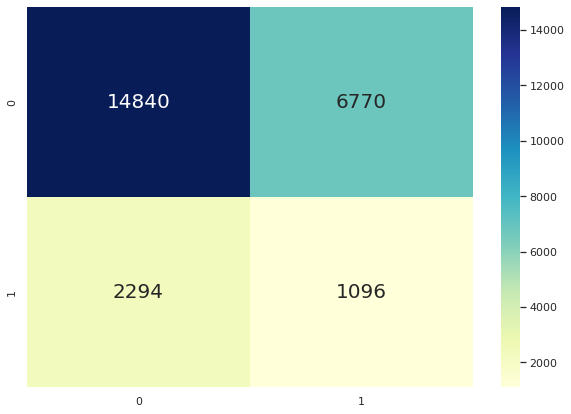

In [35]:
predicted = pre[0]
true = main[0]
for i in range(1,len(main)):
    predicted = torch.cat((predicted, pre[i]), -1 )
    true = torch.cat((true, main[i]), -1 )
visualize_result(true,predicted)

In [31]:
#!mkdir models
#plt.plot(range())
torch.save(model.state_dict(), "models/model")

In [33]:
model = DeepWide(categorial_featurs_dims,emmbeded_hyper,MLP_dims,numerical_dim)
model.load_state_dict(torch.load("models/model3"))
model.eval()

DeepWide(
  (embeding): Embedding(10507, 7)
  (FXlayer): Sequential(
    (0): Linear(in_features=99, out_features=1, bias=True)
    (1): ReLU()
  )
  (MLP): Sequential(
    (0): Linear(in_features=99, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): ReLU()
    (14): Linear(in_features=32, out_features=16, bias=True)
    (15): ReLU()
    (16): Linear(in_features=16, out_features=8, bias=True)
    (17): ReLU()
    (18): Linear(in_features=8, out_features=4, bias=True)
    (19): ReLU()
    (20): Linear(in_features=4, out_features=1, bi

In [37]:
print(model)
print("parameters")
for parameter in model.parameters():
    if parameter.requires_grad:
        print(parameter.size())
num_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print(num_params)

DeepWide(
  (embeding): Embedding(10507, 7)
  (FXlayer): Sequential(
    (0): Linear(in_features=99, out_features=1, bias=True)
    (1): ReLU()
  )
  (MLP): Sequential(
    (0): Linear(in_features=99, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): ReLU()
    (14): Linear(in_features=32, out_features=16, bias=True)
    (15): ReLU()
    (16): Linear(in_features=16, out_features=8, bias=True)
    (17): ReLU()
    (18): Linear(in_features=8, out_features=4, bias=True)
    (19): ReLU()
    (20): Linear(in_features=4, out_features=1, bi

In [56]:
class DeepWide2(nn.Module):
    def __init__(self,cat_F_dims,emmbeded_hyper,MLP_dims,numerical_dim):
        super(DeepWide2,self).__init__()
        cat_dims = sum(cat_F_dims)
        self.embeding = nn.Embedding(cat_dims, emmbeded_hyper)
        input_dims = numerical_dim + len(cat_F_dims) * emmbeded_hyper
        
        modules = []
        for output in MLP_dims:
            modules.append(nn.Linear(input_dims, output))
            modules.append(nn.ReLU())
            input_dims = output
        self.MLP = nn.Sequential(*modules)
        self.Flatten = nn.Flatten()
        self.sigmoid = nn.Sigmoid()
        input_dims+= numerical_dim #+ len(cat_F_dims) * emmbeded_hyper
        self.FXlayer = nn.Sequential(nn.Linear(input_dims, 1),nn.ReLU())
    def forward(self,x1,x2):
        embedded_output = torch.Tensor(self.embeding(x1.to(torch.int64)))
        square_of_sum = torch.sum(embedded_output, axis=1) ** 2
        sum_of_square = torch.sum(embedded_output ** 2, axis=1)
        embedded_output2 = self.Flatten(embedded_output)
        cated_input = torch.cat((embedded_output2, x2), -1 )
        x3 = self.MLP(cated_input)
        cated_input2 = torch.cat((cated_input,x3), -1 )
        z = self.FXlayer(cated_input2)
        z+=0.5 * (square_of_sum - sum_of_square).sum(1, keepdims=True)
        return self.sigmoid(z).reshape(-1)

In [57]:
numerical_dim = len(numerical_col)
emmbeded_hyper = 9
MLP_dims = [2048,1024,512,256,128]
model2 = DeepWide2(categorial_featurs_dims,emmbeded_hyper,MLP_dims,numerical_dim)
optimizer2 = torch.optim.SGD(model2.parameters(),lr=0.005)
loss_function2 = nn.BCELoss()
BATCH_SIZE2 = 256
NUMBER_OF_EPOCHS2 = 40

In [58]:
from statistics import mean
all_train_losses = []
all_train_accuracy = []
all_val_losses = []
all_val_accuracy = []
for epoch in range(NUMBER_OF_EPOCHS2):
    # training
    epoch_loss = 0
    correct = 0
    acc_list = []
    epoch_all = 0
    model.train()
    with tqdm.tqdm(enumerate(train_loader), total=len(train_loader)) as pbar:
        for i, (x1,x2, y) in pbar:
            optimizer2.zero_grad()
            outputs = model2(x1,x2)
            loss = loss_function2(outputs , y)
            loss.backward()
            optimizer.step()
            epoch_loss += outputs.shape[0] * loss.item()
            epoch_all += y.size(0)
            predicted = torch.floor(outputs)
            correct += (predicted == y).sum().item()
            pbar.set_description(f'epoch {epoch } - train Loss: {epoch_loss / (i + 1):.3e} - train Acc: {correct * 100. / epoch_all:.2f}%')
    loss_list = []
    model.eval() 
    with torch.no_grad():
        main = []
        pre = []
        epoch_loss = 0
        epoch_all = 0
        correct = 0
        corr = 0
        tot = 0
        with tqdm.tqdm(enumerate(val_loader), total=len(val_loader)) as pbar:
            for i, (x1,x2, y) in pbar:
                out = model2(x1,x2)
                los = loss_function2(out , y).item()
                main.append(y)
                epoch_loss += los
                loss_list.append(los)
                predicts = torch.floor(out)
                pre.append(predicts)
                epoch_all+=y.size(0)
                tot += y.size(0)
                correct += (predicts == y).sum().item()
                pbar.set_description(f'epoch {epoch } - val Loss: {epoch_loss / (i + 1):.3e} - val Acc: {correct * 100. / epoch_all:.2f}%')


epoch 0 - train Loss: 9.966e+03 - train Acc: 58.87%: 100%|█| 293/293 [00:19<00:0
epoch 0 - val Loss: 8.369e+01 - val Acc: 16.00%: 100%|█| 98/98 [00:03<00:00, 31.
epoch 1 - train Loss: 9.881e+03 - train Acc: 59.20%: 100%|█| 293/293 [00:20<00:0
epoch 1 - val Loss: 8.369e+01 - val Acc: 16.00%: 100%|█| 98/98 [00:02<00:00, 41.
epoch 2 - train Loss: 9.897e+03 - train Acc: 59.15%: 100%|█| 293/293 [00:20<00:0
epoch 2 - val Loss: 8.369e+01 - val Acc: 16.00%: 100%|█| 98/98 [00:02<00:00, 42.
epoch 3 - train Loss: 9.958e+03 - train Acc: 58.89%: 100%|█| 293/293 [00:20<00:0
epoch 3 - val Loss: 8.369e+01 - val Acc: 16.00%: 100%|█| 98/98 [00:02<00:00, 35.
epoch 4 - train Loss: 9.920e+03 - train Acc: 59.12%: 100%|█| 293/293 [00:21<00:0
epoch 4 - val Loss: 8.369e+01 - val Acc: 16.00%: 100%|█| 98/98 [00:03<00:00, 28.
epoch 5 - train Loss: 1.005e+04 - train Acc: 58.56%: 100%|█| 293/293 [00:23<00:0
epoch 5 - val Loss: 8.369e+01 - val Acc: 16.00%: 100%|█| 98/98 [00:03<00:00, 29.
epoch 6 - train Loss: 9.927e

KeyboardInterrupt: 